In [1]:
import keras
print(f"Keras Version: {keras.__version__}")
import tensorflow as tf
print(f"Tensorflow Version {tf.__version__}")

Using TensorFlow backend.


Keras Version: 2.0.4
Tensorflow Version 1.1.0


[Keras](https://keras.io/) is a high level wrapper (API) for Tensorflow and Theano which aims to make them easier to use. Tensorflow gets quite verbose and there is a lot of detail to handle, which Keras trys to abstract away to sane defaults, while allowing the option to tinker with the tensors where wanted.

# the data

To get a feel for Keras, I'm seeing how it goes with MNIST. 

Keras already has some [datasets included](https://keras.io/datasets/), so using the ever popular mnist:

> ** MNIST database of handwritten digits**

> Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

In [15]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Checking the data:

In [3]:
f"Shapes x_train: {x_train.shape}, y_train: {y_train.shape}, x_test: {x_test.shape}, y_test: {y_test.shape}"

'Shapes x_train: (60000, 28, 28), y_train: (60000,), x_test: (10000, 28, 28), y_test: (10000,)'

The train and test images are `28x28` sized images, which we need to reshape into a 1d vector to make our super simple NN deal with. 

Now, it's a good idea to always eyeball the data, so here goes:

In [4]:
# min to max values in x_train
x_train.min(), x_train.max()

(0, 255)

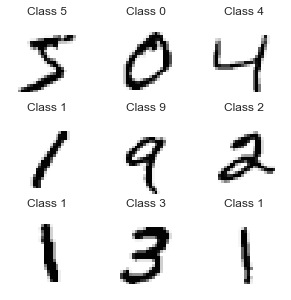

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(3,3, figsize=(5,5))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(x_train[i])
    ax.set_title(f"Class {y_train[i]}")
    ax.set_xticks([]) , ax.set_yticks([]) 

In [8]:
y_train[:9]

array([5, 0, 4, 1, 9, 2, 1, 3, 1], dtype=uint8)

ok, we've seen the data, but we need to preprocess it into a neural net friendly shape. 

## preprocessing the data

The image data is 60K `28x28` images, and the image test data is 10K `28x28` images. Unlike a simple NN, a convultional net can use the spatial data, so no need to flatten out the `28x28` image.

We still need to normalize the data:

In [16]:
X_train = x_train.astype('float32') / 255
X_test = x_test.astype('float32') / 255
X_train.min(), X_train.max()

(0.0, 1.0)

Keras expects images to have a depth - which generally with images means they have different colors, like RGB etc. the MNIST data is greyscale and thus doesn't have a depth, but we need to assign a 1 since Keras needs the depth specified. We know the image is `28x28`, so below we are just adding a 1:

In [17]:
print(x_train.shape)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
print(X_train.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


Moving on to the image labels:

the image labels are stored as a simple numpy array, with each entry telling us what number each corresponding drawing is. Since our NN will spit out a prediction of the likelyhood of what number the drawing is, our NN will work better with the y data [one hot encoded](https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science).

In [18]:
print("Existing image labels")
print(f"y_train: {y_train[:10]} | y_test: {y_test[:10]}")

from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)

print(f"Y_Train encoded: {Y_train[0]}")
print(f"Y_test encoded: {Y_test[0]}")

Existing image labels
y_train: [5 0 4 1 9 2 1 3 1 4] | y_test: [7 2 1 0 4 1 4 9 5 9]
Y_Train encoded: [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
Y_test encoded: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


so now our data is all ready to go!

# convultional neural net

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

model = Sequential()

model.add(Conv2D(16,(2,2), input_shape=(28,28,1), activation='relu'))
model.add(Dropout(0.05))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.05))

# the weights from the Conv2D layer have to be made 1D for the Dense layer
model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.05))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# we can either use part of the training set as validation data or provide a validation set
history = model.fit(X_train, Y_train, epochs=5, batch_size=128, shuffle=True, 
                    validation_split=0.05, callbacks=[early_stopping])

#model.fit(X_train, Y_train, epochs=10, batch_size=128, shuffle=True, validation_data=(X_test,Y_test))

Train on 57000 samples, validate on 3000 samples
Epoch 1/5
57000/57000 [==============================] - 84s - loss: 0.2561 - acc: 0.9225 - val_loss: 0.1235 - val_acc: 0.9613
Epoch 2/5
57000/57000 [==============================] - 97s - loss: 0.0761 - acc: 0.9763 - val_loss: 0.0527 - val_acc: 0.9877
Epoch 3/5
57000/57000 [==============================] - 101s - loss: 0.0515 - acc: 0.9838 - val_loss: 0.0452 - val_acc: 0.9893
Epoch 4/5
57000/57000 [==============================] - 106s - loss: 0.0400 - acc: 0.9877 - val_loss: 0.0568 - val_acc: 0.9873
Epoch 5/5
57000/57000 [==============================] - 93s - loss: 0.0316 - acc: 0.9900 - val_loss: 0.0441 - val_acc: 0.9903


In [41]:
model.evaluate(X_test, Y_test, batch_size=256)

 9984/10000 [============================>.] - ETA: 0s

[0.040342996675986793, 0.98729999999999996]

and viola, this pretty simple CNN gets over 98% accuracy!

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 27, 27, 16)        80        
_________________________________________________________________
dropout_23 (Dropout)         (None, 27, 27, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 26, 26, 32)        2080      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                346176    
__________

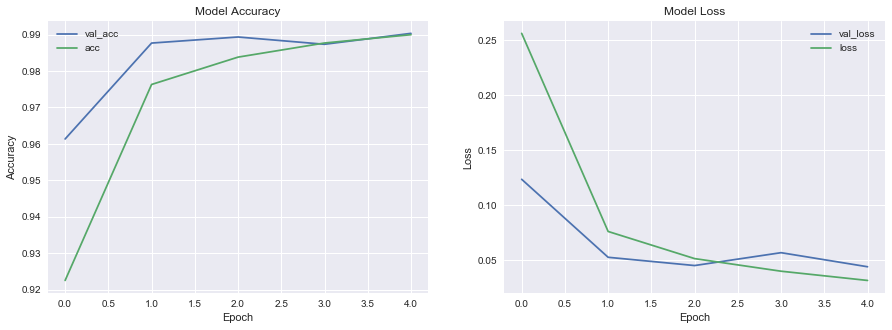

In [40]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

acc = axs[0]
acc.plot(history.history['val_acc'])
acc.plot(history.history['acc'])
acc.legend(['val_acc', 'acc'])
acc.set_title('Model Accuracy')
acc.set_ylabel('Accuracy')
acc.set_xlabel('Epoch')

loss = axs[1]
loss.plot(history.history['val_loss'])
loss.plot(history.history['loss'])
loss.legend(['val_loss', 'loss'])
loss.set_title('Model Loss')
loss.set_ylabel('Loss')
loss.set_xlabel('Epoch')
plt.show();